# Práctico 1: Recomendación de Artistas
<h3><FONT COLOR="#FF0000"> Alumno: Zoppini Maximo (Omega)</FONT></h3>


En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [1]:
import pandas as pd
import numpy as np
import random

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)


In [2]:
artist_data = pd.read_csv('C:/Users/Maxim/Downloads/hetrec2011-lastfm-2k/artists.dat', sep = '\t')
display(artist_data.head())
artist_data.shape


,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


(17632, 4)

In [3]:
#user_artist_plays...

user_artist_plays = pd.read_csv('C:/Users/Maxim/Downloads/hetrec2011-lastfm-2k/user_artists.dat', sep = '\t')
display(user_artist_plays.head())
user_artist_plays.shape


,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


(92834, 3)

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [4]:
#¿Cuáles son los artistas que fueron más escuchados?

artist_dicc = pd.Series(artist_data.name.values, index = artist_data.id).to_dict()

top10_artist = pd.pivot_table(user_artist_plays, index = ['artistID'], values = ['weight'], aggfunc = sum, fill_value = 0).reset_index().sort_values(by = 'weight', ascending = False).rename(columns = {'weight':'repro'}).head(10)
top10_artist.insert(1, 'name', top10_artist.artistID.map(artist_dicc))

display(top10_artist)
top10_artist.shape


,artistID,name,repro
283,289,Britney Spears,2393140
66,72,Depeche Mode,1301308
83,89,Lady Gaga,1291387
286,292,Christina Aguilera,1058405
492,498,Paramore,963449
61,67,Madonna,921198
282,288,Rihanna,905423
695,701,Shakira,688529
221,227,The Beatles,662116
294,300,Katy Perry,532545


(10, 3)

,count,mean,std,min,25%,50%,75%,max
weight,1892.0,36566.582981,48744.552394,3.0,9742.25,21573.0,42963.75,480039.0


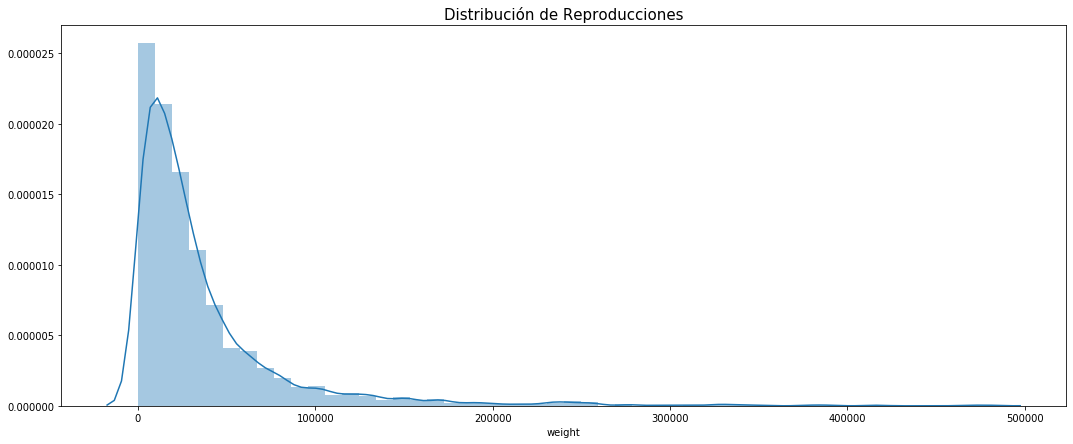

In [6]:
#¿Cómo es la distribución de cantidad de listens por user?

display(pd.pivot_table(user_artist_plays, index = ['userID'], values = ['weight'], aggfunc = sum, fill_value = 0).describe().T)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (18, 7))

plt.title('Distribución de Reproducciones', fontsize = 15)
sns.distplot(pd.pivot_table(user_artist_plays, index = ['userID'], values = ['weight'], aggfunc = sum, fill_value = 0).weight)

plt.show()


In [7]:
#¿Es posible ver el género más escuchado?

tags_dat = pd.read_csv('C:/Users/Flavio/Downloads/hetrec2011-lastfm-2k/tags.dat', sep = '\t', encoding = 'latin-1')
tags_dicc = pd.Series(tags_dat.tagValue.values, index = tags_dat.tagID).to_dict()

user_taggedartists_dat = pd.read_csv('C:/Users/Flavio/Downloads/hetrec2011-lastfm-2k/user_taggedartists.dat', sep = '\t')

top10_tag = pd.DataFrame(user_taggedartists_dat.tagID.value_counts())[0:10].reset_index().rename(columns = {'index':'id', 'tagID':'repro'})
top10_tag.insert(1, 'name', top10_tag.id.map(tags_dicc))

top10_tag


,id,name,repro
0,73,rock,7503
1,24,pop,5418
2,79,alternative,5251
3,18,electronic,4672
4,81,indie,4458
5,130,female vocalists,4228
6,25,80s,2791
7,39,dance,2739
8,78,alternative rock,2631
9,192,classic rock,2287


In [8]:
user_artist_plays


,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [9]:
#genero diccionario con la cantidad total de reproducciones por Usuario...
#... y mapeo sobre user_artist_plays.

if 'Sum' in user_artist_plays.columns:
    user_artist_plays.drop(['Sum'], axis = 1, inplace = True)
    
if 'weight_N' in user_artist_plays.columns:
    user_artist_plays.drop(['weight_N'], axis = 1, inplace = True)
    
user_artist_plays_Sum = user_artist_plays.groupby(['userID']).sum().reset_index().rename(columns = {'weight':'Sum'})

user_artist_plays_Sum_dicc = pd.Series(user_artist_plays_Sum.Sum.values, index = user_artist_plays_Sum.userID).to_dict()
user_artist_plays.insert(3, 'Sum', user_artist_plays.userID.map(user_artist_plays_Sum_dicc))

user_artist_plays['weight_N'] = user_artist_plays['weight'] / user_artist_plays['Sum']

user_artist_plays


,userID,artistID,weight,Sum,weight_N
0,2,51,13883,168737,0.082276
1,2,52,11690,168737,0.069279
2,2,53,11351,168737,0.067270
3,2,54,10300,168737,0.061042
4,2,55,8983,168737,0.053237
...,...,...,...,...,...
92829,2100,18726,337,30877,0.010914
92830,2100,18727,297,30877,0.009619
92831,2100,18728,281,30877,0.009101
92832,2100,18729,280,30877,0.009068


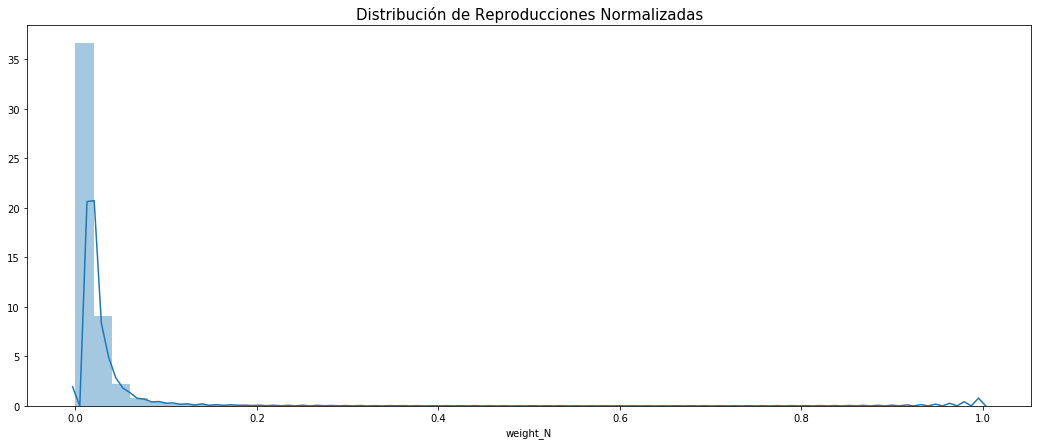

In [10]:
#¿Cómo se distribuyen ahora los listens Normalizados por user?

plt.figure(figsize = (18, 7))

plt.title('Distribución de Reproducciones Normalizadas', fontsize = 15)
sns.distplot(user_artist_plays.weight_N)

plt.show()


## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [11]:
#mapeamos tabla user_artist_plays con nombre del artista...

all_artist_dicc = pd.Series(artist_data.name.values, index = artist_data.id).to_dict()

user_artist_plays_map = user_artist_plays.copy()
user_artist_plays_map.insert(2, 'name', user_artist_plays_map.artistID.map(all_artist_dicc))

user_artist_plays_map


,userID,artistID,name,weight,Sum,weight_N
0,2,51,Duran Duran,13883,168737,0.082276
1,2,52,Morcheeba,11690,168737,0.069279
2,2,53,Air,11351,168737,0.067270
3,2,54,Hooverphonic,10300,168737,0.061042
4,2,55,Kylie Minogue,8983,168737,0.053237
...,...,...,...,...,...,...
92829,2100,18726,Nyktalgia,337,30877,0.010914
92830,2100,18727,Atsakau niekadA,297,30877,0.009619
92831,2100,18728,Domantas Razauskas,281,30877,0.009101
92832,2100,18729,Atalyja,280,30877,0.009068


In [12]:
#nombres únicos...

print(user_artist_plays_map.name.nunique())
print(user_artist_plays_map.artistID.nunique())


17632
17632


In [13]:
#pivoteamos user_artist_plays_map para generar una matriz usuario-contenido (dispersa)...

mtrx_user_artist_plays = pd.pivot_table(user_artist_plays_map, index = ['userID'], columns = ['artistID'], values = ['weight_N'], aggfunc = sum, fill_value = 0)
mtrx_user_artist_plays


weight_N                                                          \
artistID    1     2         3     4     5         6     7     8     9       
userID                                                                      
2             0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
3             0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
4             0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
5             0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
6             0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
...           ...   ...       ...   ...   ...       ...   ...   ...   ...   
2095          0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
2096          0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
2097          0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
2099          0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   0.0   
2100          0.0   0.0  0.013214   0.0   0.0  0.013084   0.0   0.0   0.0   

                ...                                                        \
artistID 10     ... 18736 18737 18738 18739 18740 18741 18742 18743 18744   
userID          ...                                                         
2          0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3          0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6          0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...        ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2095       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2096       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2097       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2099       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2100       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                
artistID 18745  
userID          
2          0.0  
3          0.0  
4          0.0  
5          0.0  
6          0.0  
...        ...  
2095       0.0  
2096       0.0  
2097       0.0  
2099       0.0  
2100       0.0  

[1892 rows x 17632 columns]

In [14]:
#acomodamos las columnas...

mtrx_user_artist_plays.columns = all_artist_dicc.values()
#mtrx_user_artist_plays.reset_index(inplace = True)

mtrx_user_artist_plays


,MALICE MIZER,Diary of Dreams,Carpathian Forest,Moi dix Mois,Bella Morte,Moonspell,Marilyn Manson,DIR EN GREY,Combichrist,Grendel,...,LOSTFREEQ,Ciccone Youth,Cubanate,Apollo 440,Die Krupps,Diamanda Galás,Aya RL,Coptic Rain,Oz Alchemist,Grzegorz Tomczak
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#calculamos la dispersión dividiendo el número de elementos almacenados por el número total de elementos...

n_tot = mtrx_user_artist_plays.shape[0] * mtrx_user_artist_plays.shape[1]
n_rat = mtrx_user_artist_plays.astype(bool).sum().sum()
sparsity = n_rat / n_tot

print(f'Matrix sparsity: {round(sparsity * 100, 2)}%')


Matrix sparsity: 0.28%


## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [16]:

from surprise import Dataset, Reader
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering

reader = Reader(rating_scale = (user_artist_plays.weight_N.min(), user_artist_plays.weight_N.max()))

ratings = Dataset.load_from_df(user_artist_plays[['userID', 'artistID', 'weight_N']], reader)


In [17]:

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, ratings, measures = ['RMSE'], cv = 5, verbose = False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index = ['Algorithm']))
    benchmark.append(tmp)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

In [18]:

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.036631,0.364011,0.118994
KNNBasic,0.037205,0.741747,2.337617
KNNBaseline,0.037596,1.090654,2.837402
KNNWithMeans,0.037965,0.819601,2.367202
SlopeOne,0.038074,19.957307,3.142864
KNNWithZScore,0.039098,0.973582,2.743220
NMF,0.042095,8.644488,0.346302
CoClustering,0.042581,4.079161,0.163600
SVDpp,0.044799,64.006196,1.278590


In [19]:

model_als = BaselineOnly()

ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2)

predictions_als = model_als.fit(ratings_train).test(ratings_test)

print("RMSE on test: {:.4f}".format(rmse(predictions_als, verbose = False)))


Estimating biases using als...
RMSE on test: 0.0370


## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

##### Desde Surprise intentaremos, dado un item, encontrar los más cercanos (similares)...

In [21]:
#buscamos la mejor combinación de parámetros para KNNBasic

from surprise.model_selection import GridSearchCV

param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [10, 20, 30, 40],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

KNNBasic_gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 5)

KNNBasic_gs.fit(ratings)

#mejor score...
print(KNNBasic_gs.best_score['rmse'])

#mejor combinación para el anterior score...
print(KNNBasic_gs.best_params['rmse'])


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix.

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix.

In [22]:
#intentamos encontrar los items más parecidos al buscado.

trainset = ratings.build_full_trainset()

#model = KNNBasic(k = 40, bsl_options= {'method': 'als', 'reg': 1}, sim_options = {'name': 'cosine', 'user_based': False}, verbose = False)
model = KNNBasic_gs.best_estimator['rmse']
model.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [27]:
#

def find_artist_nearest(name, k):
    # Retrieve id of the artist.
    artist_name = name
    artist_id = int(artist_data[artist_data.name == artist_name].id.values)
    
    # Retrieve ids of the nearest neighbors.
    artist_ids_neighbors = model.get_neighbors(artist_id, k)
    
    # Convert ids of the neighbors into names.
    artist_names_neighbors = [artist_data[artist_data.id == ids].name  for ids in artist_ids_neighbors]
    
    print('{} Recomendaciones para {}:'.format(k, name))
    print()
    for i in artist_names_neighbors:
        print(i.tolist())

def busca_artista(artist):
    return artist_data[artist_data['name'].str.contains(artist)]['name'].tolist()

artist_idx = dict(zip(artist_data['name'], list(artist_data.id)))


In [28]:
#select an artist...

name = busca_artista('Beatles')[0]
n_recommendations = 10

find_artist_nearest(name, k = n_recommendations)


10 Recomendaciones para The Beatles:

[':wumpscut:']
['Tamtrum']
['Opeth']
['Poets of the Fall']
['Tears for Fears']
['Death Cab for Cutie']
['Man Man']
['M. Ward']
['Wolf Parade']
['3OH!3']


In [29]:
#

user_artist_plays[['userID', 'artistID', 'weight_N']].head()


,userID,artistID,weight_N
0,2,51,0.082276
1,2,52,0.069279
2,2,53,0.067270
3,2,54,0.061042
4,2,55,0.053237


In [30]:
#utilizaremos filtrado colaborativo para generar recomendaciones (a personas similares les gustan cosas similares)...
#... llevamos la data a una matriz usuario-item.

from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        artist_mapper: dict that maps movie id's to artist indices
        artist_inv_mapper: dict that maps movie indices to artist id's
    """
    M = df['userID'].nunique()
    N = df['artistID'].nunique()

    user_mapper = dict(zip(np.unique(df['userID']), list(range(M))))
    artist_mapper = dict(zip(np.unique(df['artistID']), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df['userID'])))
    artist_inv_mapper = dict(zip(list(range(N)), np.unique(df['artistID'])))
    
    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [artist_mapper[i] for i in df['artistID']]

    X = csr_matrix((df['weight_N'], (user_index, item_index)), shape = (M, N))
    
    return X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper

X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper = create_X(user_artist_plays)


In [31]:
#calculamos la dispersión dividiendo el número de elementos almacenados por el número total de elementos...
#... X.nnz cuenta los valores no zeros.

n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings / n_total

print(f'Matrix sparsity: {round(sparsity * 100, 2)}%')


Matrix sparsity: 0.28%


In [32]:
#item-item Recommendations with k-Nearest Neighbors...

from sklearn.neighbors import NearestNeighbors

def find_similar_artists(artist_id, X, artist_mapper, artist_inv_mapper, k, metric = 'cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    artist_ind = artist_mapper[artist_id]
    artist_vec = X[artist_ind]
    
    if isinstance(artist_vec, (np.ndarray)):
        artist_vec = artist_vec.reshape(1,-1)
        
    # use k+1 since kNN output includes the artistID of interest
    kNN = NearestNeighbors(n_neighbors = k + 1, algorithm = 'brute', metric = metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(artist_vec, return_distance = False)
    
    for i in range(0, k):
        n = neighbour.item(i)
        neighbour_ids.append(artist_inv_mapper[n])
        
    neighbour_ids.pop(0)
    return neighbour_ids

def artist_finder(artist):
    return artist_data[artist_data['name'].str.contains(artist)]['name'].tolist()

artist_idx = dict(zip(artist_data['name'], list(artist_data.id)))

#artist_idx = dict(zip(list(artist_data.index), artist_data['name']))


In [33]:
#n recomendaciones para...

name = artist_finder('Beatles')[0]
n_recommendations = 10

idx = artist_idx[name]
similar_artists = find_similar_artists(idx, X, artist_mapper, artist_inv_mapper, k = n_recommendations)

print('{} Recomendaciones para {} ({}):'.format(n_recommendations, name, idx))
print()
for i in similar_artists:
    print('-', list(artist_idx.keys())[list(artist_idx.values()).index(i)], '(' + str(i) + ')')


10 Recomendaciones para The Beatles (227):

- John Lennon (733)
- Paul McCartney (1414)
- Onision (6465)
- The J. Geils Band (6460)
- Leonel García (3061)
- Nicho Hinojosa (3072)
- Santo & Johnny (3066)
- Leon Polar (3064)
- Los Shakers (3059)
